In [1]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

%matplotlib inline

In [2]:
#Read input file named listings.csv from same directory as this notebook
#Create a Pandas dataframe named df and feed input file into the Pandas dataframe
df = pd.read_csv('listings.csv', low_memory=False)

#Since the column price is of dtype string we need to perform a string replace and convert it to numeric type
df['price']=df['price'].str.replace('$','')
df['price']=pd.to_numeric(df['price'],errors='coerce')

#We will do the same with 'security_deposit' as well as 'cleaning_fee' columns
df['security_deposit']=df['security_deposit'].str.replace('$','')
df['security_deposit']=pd.to_numeric(df['security_deposit'],errors='coerce')

df['cleaning_fee']=df['cleaning_fee'].str.replace('$','')
df['cleaning_fee']=pd.to_numeric(df['cleaning_fee'],errors='coerce')

#Define co-ordinate reference system
crs = {'init':'espg:4326'} 

#View top 5 rows of the dataframe 
df.head(5)

#Notice below that the input data has 106 columns from which we need to extract relevant data for this analysis
#The data also has close to 50,000 rows

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.38
2,3647,https://www.airbnb.com/rooms/3647,20190708031610,2019-07-08,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
3,3831,https://www.airbnb.com/rooms/3831,20190708031610,2019-07-09,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.64
4,5022,https://www.airbnb.com/rooms/5022,20190708031610,2019-07-08,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10


In [3]:
#Checking data types of various columns in the dataset. It is alwas good to understand the datatypes first
df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

In [4]:
#Checking number of rows in the dataset
#Using the 'pandas_profiling' package allows us to obtain a comprehensive report of data quality.
#Column level statistics, histograms, descriptions, missing values count, corellation plots can all be obtained easily.
#However, in order to not go off on a tanget with pandas_profiling, we will stick to simpler, manual checks.
len(df)

48895

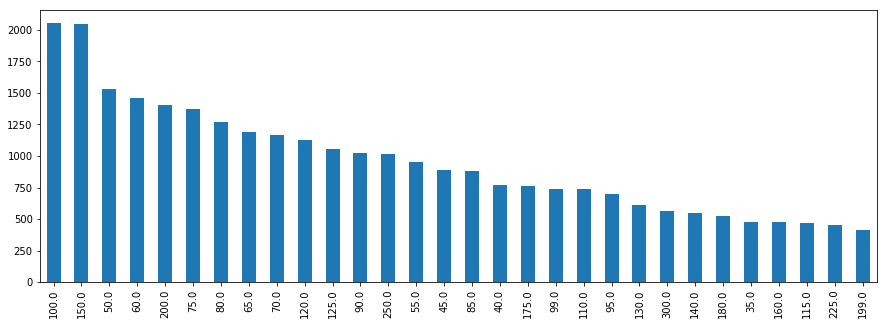

In [5]:
#Visualizing most commonly priced listings
df.price.value_counts().head(30).plot(kind = 'bar', figsize = (15, 5))

#It is clear that most common prices for listings are $100 or $150 per night. 
#Cheaper listings in the range of $50 to $80 are also quite popular

In [6]:
#Defining variable named 'geometry' which will hold latitude and longitude values of every row in the dataframe
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
geometry[1:5]

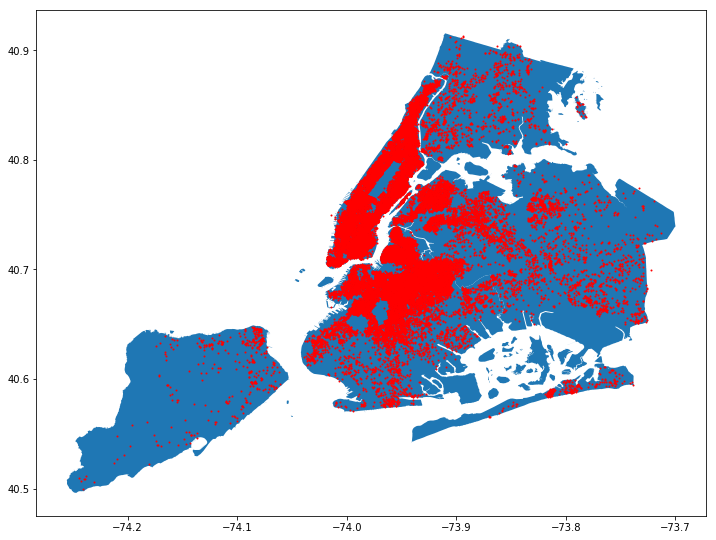

In [7]:
#Creating the 'geo_df' dataframe using Geopandas
geo_df = gpd.GeoDataFrame(df,
                         crs = crs,
                         geometry = geometry)

#Reading NYC shapefiles obtained from below link and placed in the 'Borough_Boundaries' folder inside working directory
#https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
#The 'street_map' variable will hold the geo dataframe of the shapefiles
street_map = gpd.GeoDataFrame.from_file("./Borough_Boundaries")

#Visualizing available listings on a map using the 'has_availability' column in the input dataset
#Red dots indicate available listings
fig,ax = plt.subplots(figsize = (12,12))
street_map.plot(ax = ax)
geo_df[geo_df['has_availability'] == 't'].plot(ax = ax, markersize = 1, color = "red", marker = "o", label = "Pos")

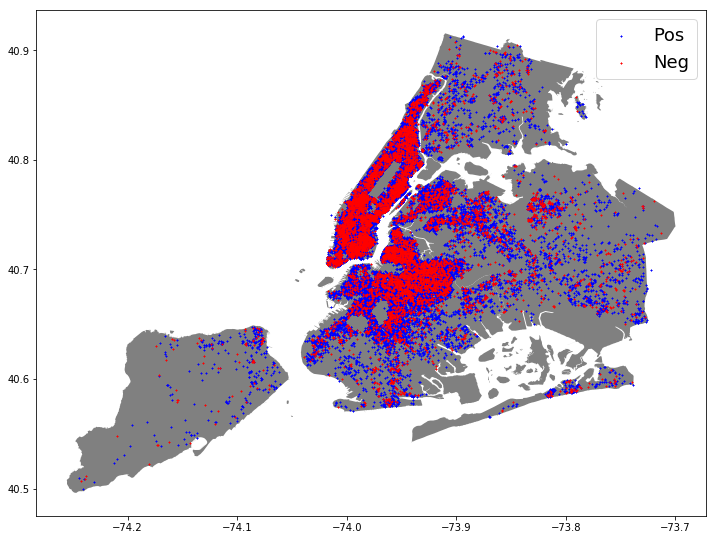

In [8]:
#Visualizing whether locations listed in the dataset are exact or not
#We will utilize the 'is_location_exact' column from the input dataset for this
fig,ax = plt.subplots(figsize = (12,12))
street_map.plot(ax = ax, color = 'grey')
geo_df[geo_df['is_location_exact'] == 't'].plot(ax = ax, markersize = 1, color = "blue", marker = "x", label = "Pos")
geo_df[geo_df['is_location_exact'] == 'f'].plot(ax = ax, markersize = 1, color = "red", marker = "x", label = "Neg")
plt.legend(prop={'size':18})

#Notice that the location co-ordinates for Manhattan and Brooklyn seem to be off in the dataset
#Perhaps due to the larger number of listings in these areas

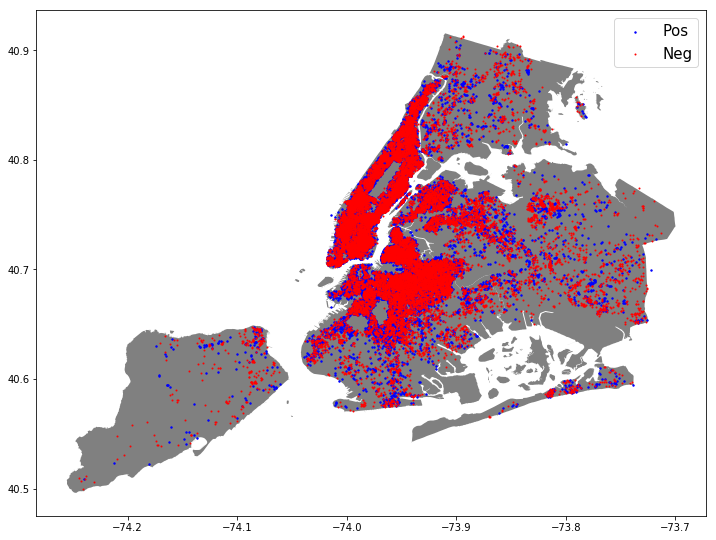

In [9]:
#Visualizing whether the host of a particular listing is verified or not
#We will use the 'host_identity_verified' column from the input dataset for this
fig,ax = plt.subplots(figsize = (12,12))
street_map.plot(ax = ax, color = 'grey')
geo_df[geo_df['host_identity_verified'] == 't'].plot(ax = ax, markersize = 2, color = "blue", marker = "o", label = "Pos")
geo_df[geo_df['host_identity_verified'] == 'f'].plot(ax = ax, markersize = 1, color = "red", marker = "o", label = "Neg")
plt.legend(prop={'size':15})

#We find that very few of the listings have a host who is verified by airbnb. Almost none in Manhattan and Brooklyn
#These neighborhoods could potentially see a higher number of rental scams. However, we will not dig deeper into it

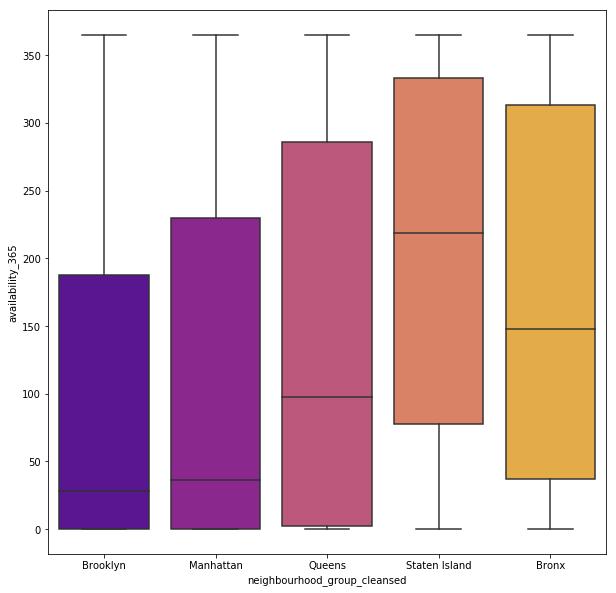

In [10]:
#Understanding availability throughout the year among the five boroughs of NYC
#Utilizing 'neighbourhood_group_cleansed' and 'availability_365' columns from the input dataset
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df, x='neighbourhood_group_cleansed',y='availability_365',palette='plasma')

#Clearly Brooklyn and Manhattan have a much lower availability throughout the year
#This tells us that properties purchased in these areas are much easier to rent out and are almost always booked out
#Staten Island has the highest availability which tells us it is harder to find guests in this area

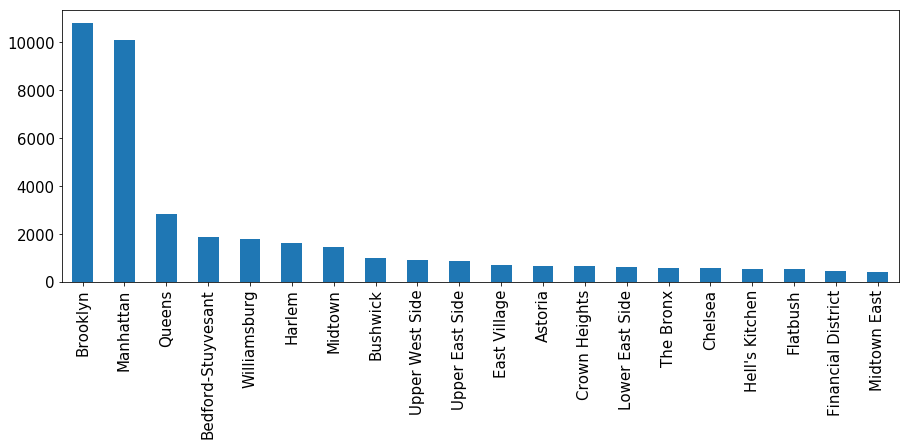

In [11]:
#Getting top 20 neighbourhoods based on most listings in the dataset
df.neighbourhood.value_counts().head(20).plot(kind = 'bar', figsize = (15,5), fontsize = 15)

#Any of these neighbourhoods would be a good bet for property purchase
#However, Brooklyn and Manhattan seem to come up as the favorites, followed by Queens 

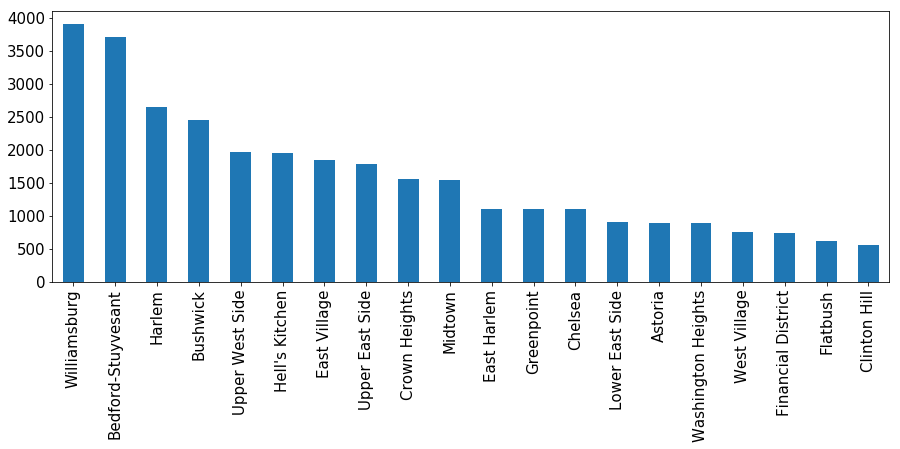

In [12]:
#Getting top 20 neighbourhoods_cleansed based on most listings in the dataset
df.neighbourhood_cleansed.value_counts().head(20).plot(kind = 'bar', figsize = (15,5), fontsize = 15)

#These are the verified names of top 20 neighborhoods where most properties/ listings are located

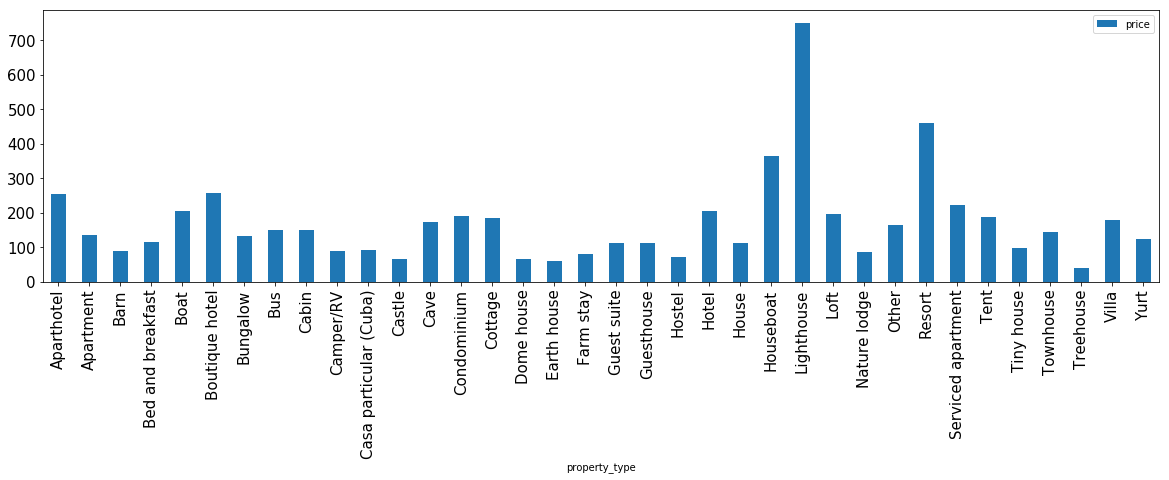

In [13]:
#Checking correlation of listing price with property type
price_property=pd.DataFrame(df[['price','property_type']])
price_property.price = pd.to_numeric(price_property.price, errors='coerce')

# Check the mean listing price for each property type
price_property_mean=price_property.groupby('property_type').mean().round(2)
price_property_mean.plot(kind = 'bar', figsize = (20,5), fontsize = 15)

#As seen below, hotels, resorts, lighthouses and houseboats are generally rented out for a higher average price
#One reason for this could be because they have lesser listings of these types compared to other property types

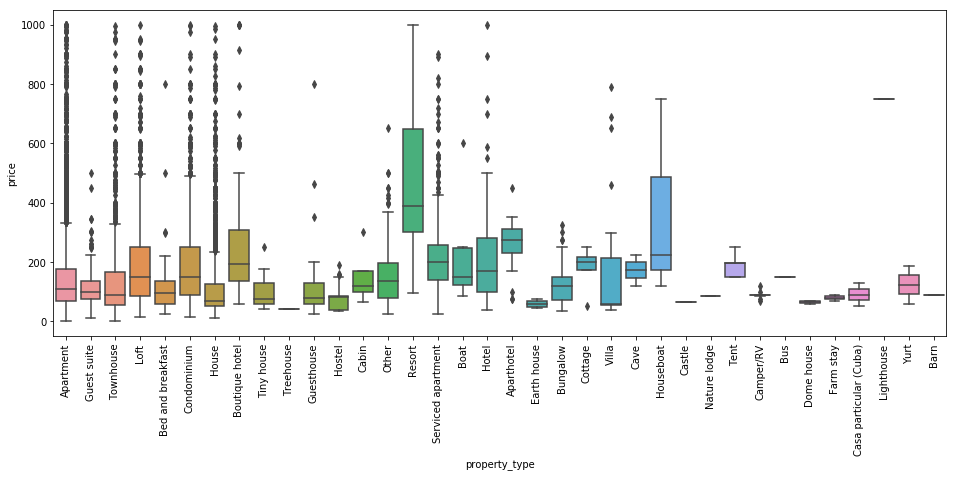

In [14]:
#Exploring the relationship between 'price' and 'property_type' using Seaborn's boxplots which makes it more intuitive
#We also get an idea of the price range and mean price per night for every property type
plt.figure(figsize=(16, 6))
sns.boxplot(x='property_type',y='price',data=price_property)
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

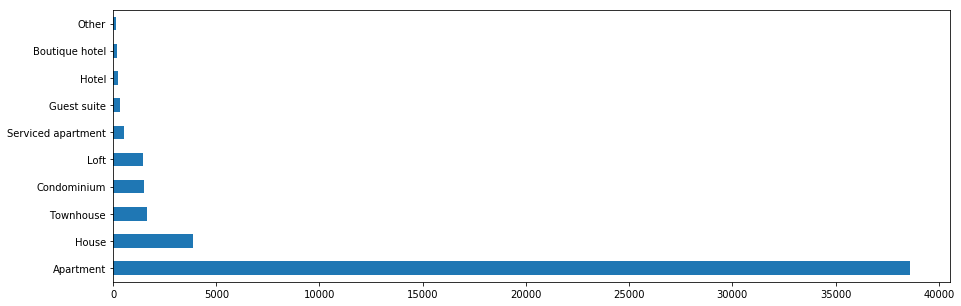

In [15]:
#Most common types of listings from the dataset
#It is clear that apartments are the most popular type of property by quite a number
price_property.property_type.value_counts().head(10).plot(kind='barh', figsize = (15, 5), fontsize = 10)

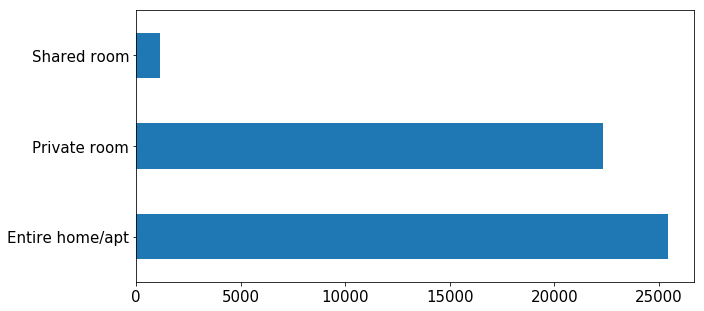

In [16]:
#Visualizing room types of listings
df.room_type.value_counts().head(25).plot(kind='barh', figsize = (10, 5), fontsize = 15)

#Entire home is the most popular choice, closely followed by private room. Not a huge difference between the two.

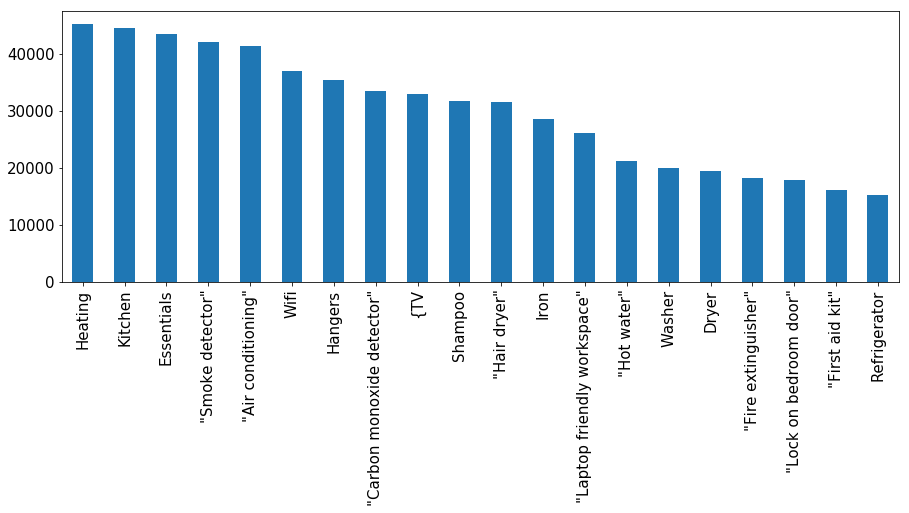

In [17]:
#Visualizing the top 20 most popular/common amenities in all the listings
#Executing lambda function on the 'amenities' column to split up strings

pd.Series(np.concatenate(df['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar', figsize = (15,5), fontsize = 15) 
    
#It is recommended that any apartment purchased must have the following 20 basic amenities

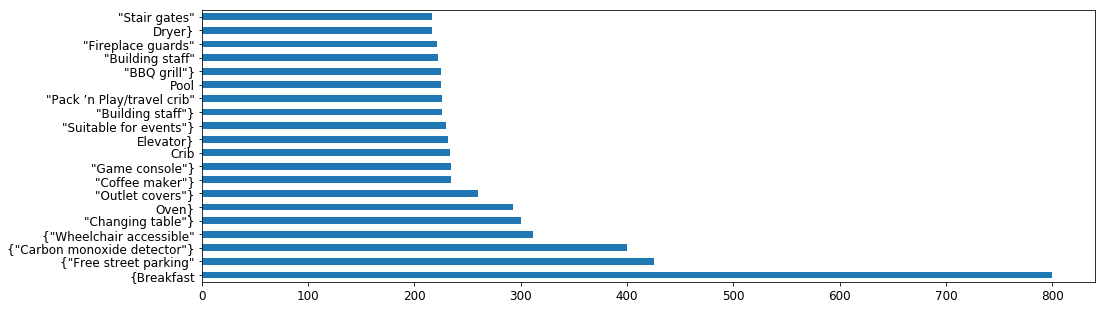

In [18]:
#Visualizing top 20 amenities which fetch the higher prices per night
price_amenities=pd.DataFrame(df[['price','amenities']]) #Creating new dataframe named price_amenities
price_amenities.price = pd.to_numeric(price_amenities.price, errors='coerce')

amenities = np.unique(np.concatenate(price_amenities['amenities'].map(lambda amns: amns.split(","))))
amenity_prices = [(amn, price_amenities[price_amenities['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])
amenity_srs.sort_values(ascending=False)[:20].plot(kind='barh', figsize = (16,5), fontsize = 12)

#Notice that breakfast, street parking and wheelchair access are some of the amenities that could increase price
#Most of these are additional conveniences apart from the above basic amenities
#It is recommended that atleast some of these amenities are addressed when purchasing a property

In [19]:
#Let's pick a few numeric features and check how they correlate with each other (and the price column)
#We are basically trying to figure out what features are closely correllated with price
#We could use Principal Component Analysis or Singular Value Decomposition for feature engineering and picking best features for making predictions using machine learning, 
#However, in the interest of time, we will not dive into those two techniques

corr_df = df[['price', 'zipcode', 'accommodates', 'beds', 'security_deposit', 'cleaning_fee', 'availability_365', 'review_scores_rating', 'review_scores_accuracy', 'reviews_per_month', 'host_id']]
corr_df.corr().style.background_gradient(cmap='coolwarm')

#Clearly, the cleaning fee and the number of people the listing can accomodate are the most highly correllated variables with price

,price,accommodates,beds,security_deposit,cleaning_fee,availability_365,review_scores_rating,review_scores_accuracy,reviews_per_month,host_id
price,1,0.533091,0.40772,0.262322,0.533759,0.117602,0.0590078,0.0135402,-0.030125,0.0358139
accommodates,0.533091,1,0.75356,0.171637,0.459818,0.148458,-0.0090243,-0.0176635,0.117543,0.0780578
beds,0.40772,0.75356,1,0.144308,0.381764,0.142553,-0.0279651,-0.0362591,0.09561,0.0872913
security_deposit,0.262322,0.171637,0.144308,1,0.371278,0.0456448,0.01898,0.00050014,-0.133465,-0.102175
cleaning_fee,0.533759,0.459818,0.381764,0.371278,1,0.183705,0.0213021,-0.0150053,-0.106269,-0.00866366
availability_365,0.117602,0.148458,0.142553,0.0456448,0.183705,1,-0.0896126,-0.0955176,0.185791,0.203492
review_scores_rating,0.0590078,-0.0090243,-0.0279651,0.01898,0.0213021,-0.0896126,1,0.742188,0.0491882,-0.0821199
review_scores_accuracy,0.0135402,-0.0176635,-0.0362591,0.00050014,-0.0150053,-0.0955176,0.742188,1,0.0750951,-0.091391
reviews_per_month,-0.030125,0.117543,0.09561,-0.133465,-0.106269,0.185791,0.0491882,0.0750951,1,0.296417
host_id,0.0358139,0.0780578,0.0872913,-0.102175,-0.00866366,0.203492,-0.0821199,-0.091391,0.296417,1


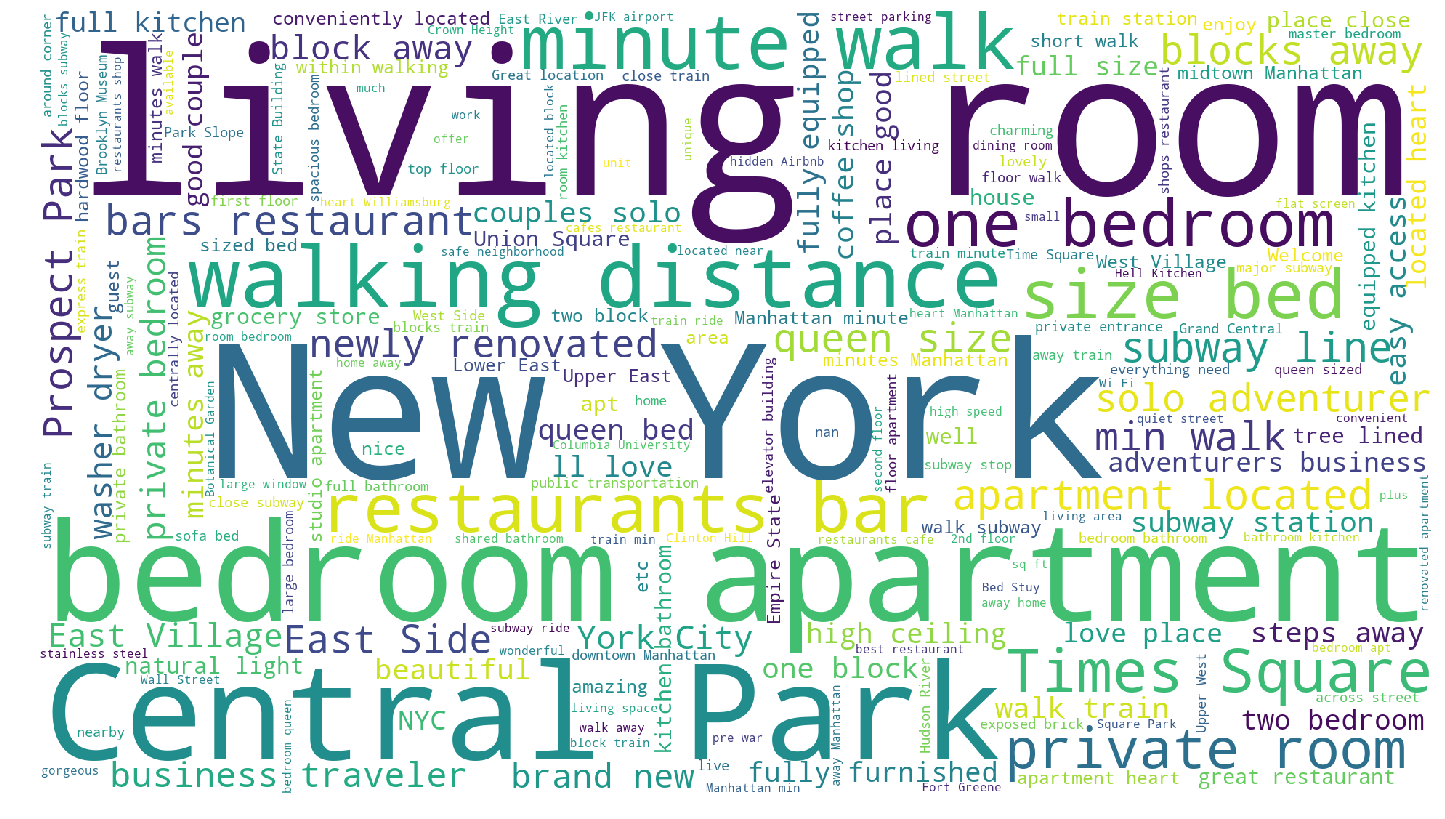

In [20]:
#Visualizing wordcloud of most popular words used in summaries from the 'summary' column in the dataset
#Bigger words indicate more importance and more frequent occurence in the dataset
df_wordcloud = pd.DataFrame(df['summary'].astype(str))
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='white',
                      width=1920,
                      height=1080).generate(" ".join(df_wordcloud.summary))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('summary.png')
plt.show()

#Notice that Central Park and Times Square are mentioned many times. 
#Perhaps this means that Central Park and Times Square are big tourist attractions. 
#Walking distance, closeness to the subway, restaurants, bars, private rooms are all important factors.
#We might want to consider purchasing properties close to Central Park and Times Square.
#It is also evident that most advertisements use phrases like "in the heart of New York City" to drive up prices.

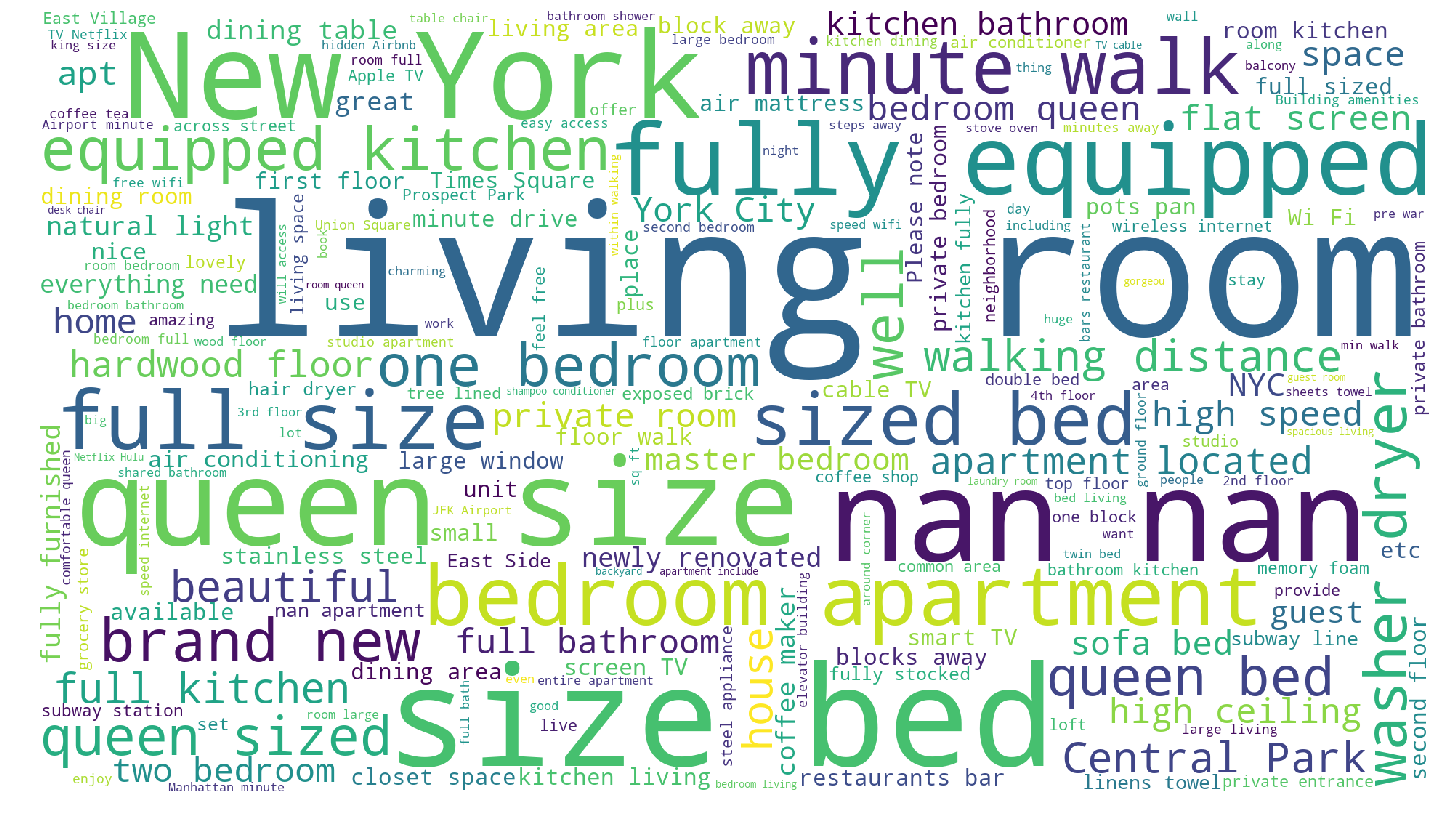

In [21]:
#Visualizing wordcloud of most popular words used in the 'space' column of the dataset
#This will give us an understanding of the type of descriptions hosts use to better sell their listings
df_wordcloud2 = pd.DataFrame(df['space'].astype(str))
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='white',
                      width=1920,
                      height=1080).generate(" ".join(df_wordcloud2.space))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('space.png')
plt.show()

#Queen sized bed seems to come up a lot. Hardwood floors, full kitchen and other amenities are also described lots.
#Also notice there's a lot of missing values in this column.
#Similar analytics could be carried out for all columns with text. We could also perform sentiment analysis on text

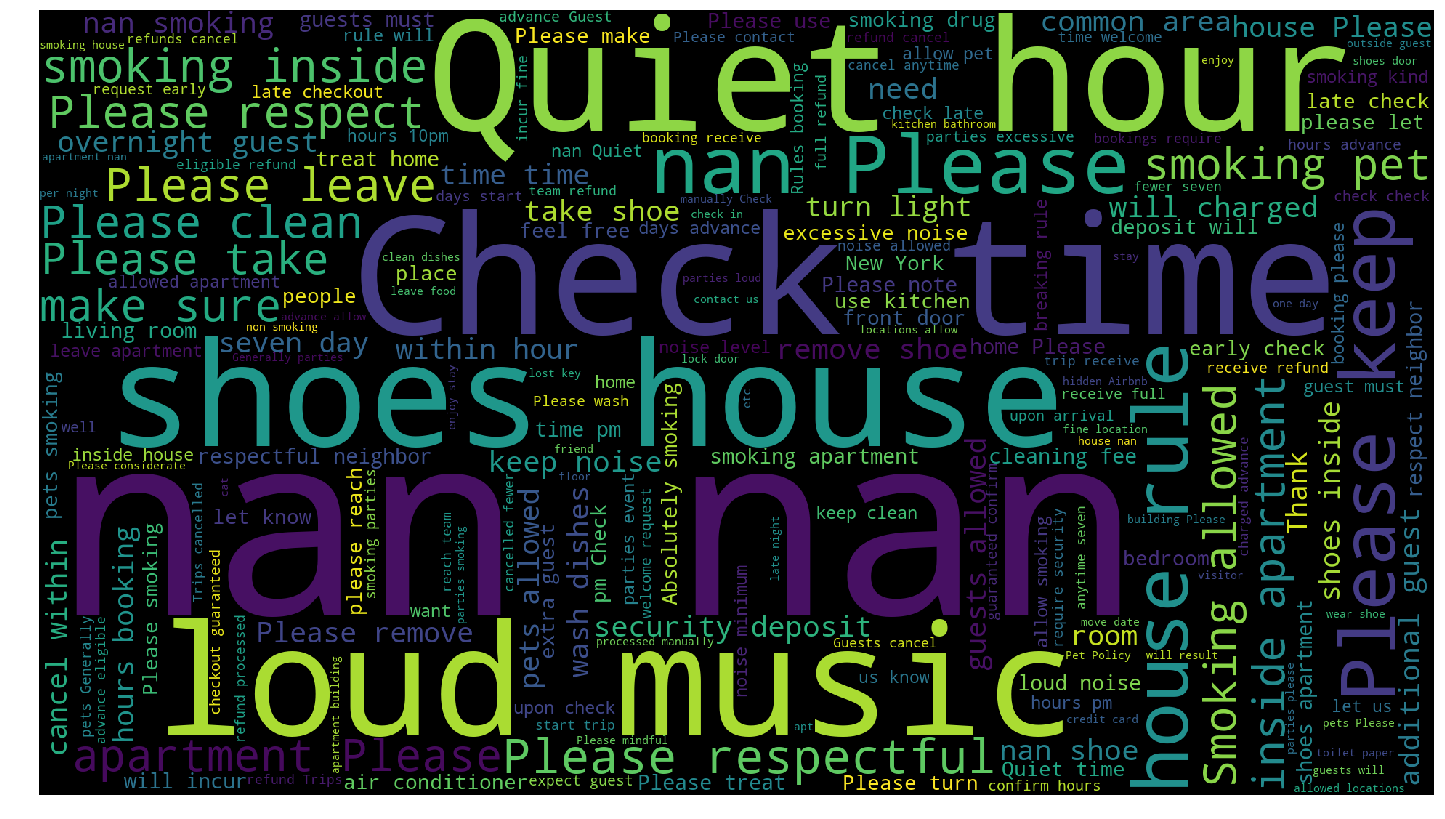

In [22]:
#Visualizing wordcloud of most popular house rules using the'house_rules' column in the dataset
#Bigger words indicate more importance and more frequent occurence in the dataset
df_wordcloud3 = pd.DataFrame(df['house_rules'].astype(str))
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080).generate(" ".join(df_wordcloud3.house_rules))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('house_rules.png')
plt.show()

#This gives us an idea of most common house rules among all listings.
#Smoking, loud music, check in / check out times and cleanliness seem to be the most common concerns of hosts
#Like before, this column also has a significant number of empty rows but we are still able to make general sense out of it

In [23]:
#Let us now narrow down on a few properties that are within a 2 mile radius of Central Park 
#We have already gathered that Central Park is a major tourist attraction and we want to stick to properties close by
#Creating a data frame, and adding data for Central Park to it
central_park = pd.DataFrame()
central_park['name'] = ["Central Park"]
central_park['lon'] = -73.968285
central_park['lat'] = 40.785091
central_park

,name,lon,lat
0,Central Park,-73.968285,40.785091


In [24]:
#Creating a geodataframe of Central Park using the 'central_park' variable
central_park= gpd.GeoDataFrame(central_park, geometry=gpd.points_from_xy(central_park.lon, central_park.lat))

Text(0.5,1,'Central Park')

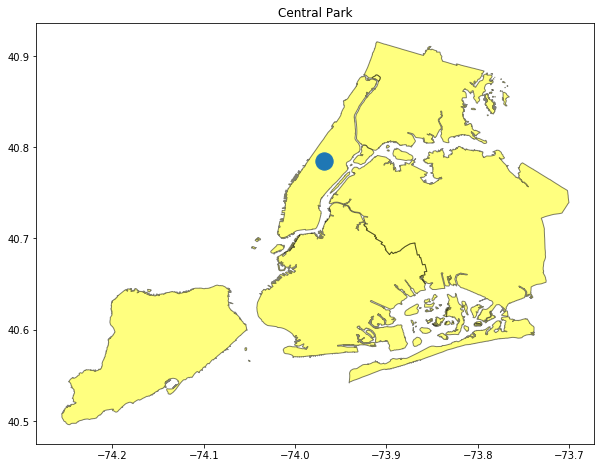

In [25]:
#Lets plot the data
#Blue dot indicates the location of Central Park on the map
fig,ax1 = plt.subplots(1,1, figsize=(10,10))
base = street_map.plot(color='yellow',alpha=0.5, edgecolor='black', ax=ax1)
central_park.plot(markersize=300,ax=base)
plt.title('Central Park')

In [26]:
#2 miles in feet is .001 * 32.195122 
central_park.crs = {'init' :'epsg:2263'}
central_park_buff = central_park.buffer(.001 * 32.195122)
central_park_buff = gpd.GeoDataFrame({'geometry': central_park_buff})
central_park_buff
central_park_buff.crs = {'init' :'epsg:2263'}
geo_df.crs = {'init' :'epsg:2263'}

In [27]:
#Getting all listings within two miles of Central Park
#Notice that we narrowed down the list to 7711 listings
airbnbs_within_2m = gpd.sjoin(geo_df,central_park_buff, how='inner', op='intersects')
len(airbnbs_within_2m)

7711

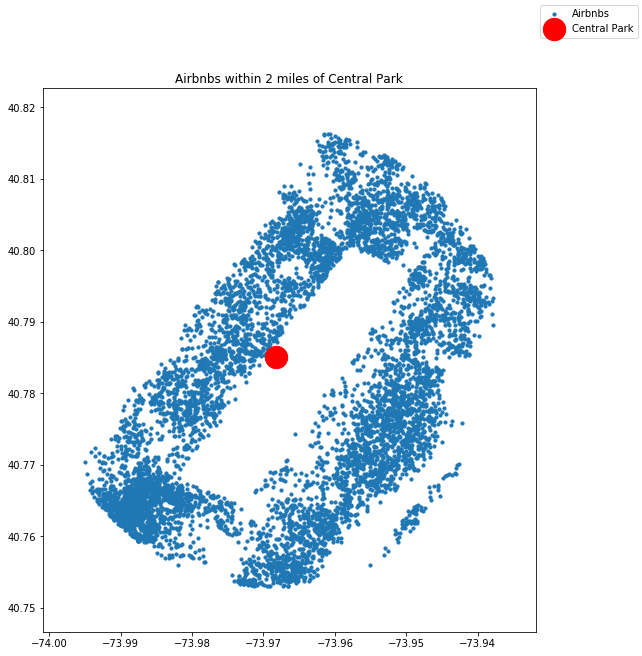

In [28]:
#Plotting all airbnbs within 2 miles of Central Park
fig,ax = plt.subplots(1,1, figsize=(10,10))
airbnbs_within_2m.plot(markersize=10,ax=ax, label="Airbnbs")
central_park.plot(markersize=500,color='red',ax=ax, label="Central Park")
plt.title("Airbnbs within 2 miles of Central Park")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [29]:
#We should now filter all airbnbs in the two mile radius that meet our criteria
print("Starting number of airbnbs: {0}".format(len(airbnbs_within_2m)))

#Filtering airbnbs with price per night less than $250
airbnbs_within_2m = airbnbs_within_2m.loc[airbnbs_within_2m['price'] < 250]
print("Number of airbnbs after cutting price per night to less than $250: {0} ".format(len(airbnbs_within_2m)))

#Filtering airbnbs with availability more than six months in a year
airbnbs_within_2m = airbnbs_within_2m.loc[airbnbs_within_2m['availability_365'] > 240]
print("Number of airbnbs after selecting those that are available at least 6 months out of the year: {0} ".format(len(airbnbs_within_2m)))

#Filtering airbnbs with atleast ten reviews
airbnbs_within_2m = airbnbs_within_2m.loc[airbnbs_within_2m['number_of_reviews'] >= 10]
print("Number of airbnbs after selecting those with at least 10 reviews: {0} ".format(len(airbnbs_within_2m)))

#Filtering airbnbs which offer entire apartment/home for rent
airbnbs_within_2m = airbnbs_within_2m.loc[airbnbs_within_2m['room_type'] == 'Entire home/apt']
print("Number of airbnbs after selecting those that offer the entire home/apt: {0} ".format(len(airbnbs_within_2m)))

#Filtering airbnbs with a minimum stay of 3 nights or less
airbnbs_within_2m = airbnbs_within_2m.loc[airbnbs_within_2m['minimum_nights'] <= 3]
print("Number of airbnbs left after selecting airbnbs that have a minimum night stay of 3 or less: {0} ".format(len(airbnbs_within_2m)))

Starting number of airbnbs: 7711
Number of airbnbs after cutting price per night to less than $250: 6214 
Number of airbnbs after selecting those that are available at least 6 months out of the year: 1304 
Number of airbnbs after selecting those with at least 10 reviews: 514 
Number of airbnbs after selecting those that offer the entire home/apt: 226 
Number of airbnbs left after selecting airbnbs that have a minimum night stay of 3 or less: 122 


In [30]:
#We have narrowed down the list to 122 airbnbs from close to 50,000 listings
#We could add more conditions and continue narrowing down as per requirement
#With the interest of time, let's stop and visualize the final 122 listings
airbnbs_within_2m

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right
51,14287,https://www.airbnb.com/rooms/14287,20190708031610,2019-07-08,Cozy 1BD on Central Park West in New York City,Spend your time in this pre-war brownstone apt...,Enjoy this cozy pre-war brownstone right on Ce...,Spend your time in this pre-war brownstone apt...,none,The most popular thing about my home is that I...,...,strict_14_with_grace_period,f,f,1,1,0,0,0.63,POINT (-73.97008 40.78635),0
274,65019,https://www.airbnb.com/rooms/65019,20190708031610,2019-07-09,Charming UWS Treehouse Apt,"Elegant eclectic decor, high ceilings, beautif...",Lovely and amazing apt with a private deck in ...,"Elegant eclectic decor, high ceilings, beautif...",none,"Very close to 72nd street subway, Fairway Mark...",...,moderate,f,f,1,1,0,0,2.10,POINT (-73.98098 40.77956),0
376,112359,https://www.airbnb.com/rooms/112359,20190708031610,2019-07-08,UES Quiet & Spacious 1 bdrm for 4,This is an awesome space in that it is 'pin dr...,Located on the same block as the subway this i...,This is an awesome space in that it is 'pin dr...,none,"I love being able to walk to Central Park, The...",...,strict_14_with_grace_period,f,f,1,1,0,0,0.57,POINT (-73.95080 40.78491),0
394,123784,https://www.airbnb.com/rooms/123784,20190708031610,2019-07-08,NYC Studio for Rent in Townhouse,"Comfortable, spacious studio in one of the mos...",This is a large studio room with a private bat...,"Comfortable, spacious studio in one of the mos...",none,"The new restaurants, stores and cafes. Everyth...",...,strict_14_with_grace_period,t,t,2,1,1,0,1.44,POINT (-73.94794 40.80481),0
508,182069,https://www.airbnb.com/rooms/182069,20190708031610,2019-07-08,Cozy studio Apartment in Upper East,"- Studio apt. for 2,3 people max - Location: 1...",Hi! great apt for rent: LOCATION: - 102nd at L...,"- Studio apt. for 2,3 people max - Location: 1...",none,metropolitana a 1 minuto a piedi central park ...,...,strict_14_with_grace_period,f,t,1,1,0,0,0.91,POINT (-73.94680 40.79056),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39611,30822815,https://www.airbnb.com/rooms/30822815,20190708031610,2019-07-08,NYC cozy studio,Conveniently located on the beautiful Roosevel...,Entire apartment.,Conveniently located on the beautiful Roosevel...,none,Nearly 57 street,...,strict_14_with_grace_period,f,f,1,1,0,0,3.37,POINT (-73.95256 40.75790),0
39865,30975764,https://www.airbnb.com/rooms/30975764,20190708031610,2019-07-08,"Walk toTimes Square,Central Park,Museums, Broa...",The apt itself is small no living room on firs...,You will feel like you’re at home the second y...,The apt itself is small no living room on firs...,none,NaN,...,strict_14_with_grace_period,f,f,5,1,4,0,4.21,POINT (-73.98956 40.76356),0
41236,32086758,https://www.airbnb.com/rooms/32086758,20190708031610,2019-07-08,Large 1bedroom Apartment in the Heart of Manha...,Location! Location! Just 2 stops to Times Squa...,I bedroom apartment - King size bed (can sleep...,Location! Location! Just 2 stops to Times Squa...,none,Irene’s home is conveniently located in the he...,...,strict_14_with_grace_period,f,f,1,1,0,0,4.05,POINT (-73.97432 40.79481),0
41727,32446696,https://www.airbnb.com/rooms/32446696,20190708031610,2019-07-08,Modern & Cozy 1 Bedroom Apt in the heart of NYC,"My Apartment is close to a lot of restaurants,...",What makes my space unique? Location Location ...,"My Apartment is close to a lot of restaurants,...",none,In my neighborhood you within Walking distance...,...,moderate,f,f,1,1,0,0,3.75,POINT (-73.98987 40.76142),0


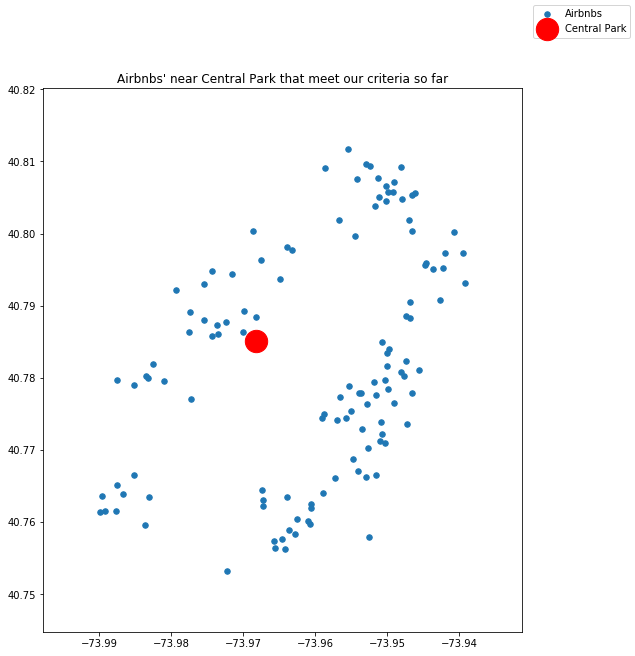

In [31]:
#Plotting the filtered airbnbs within 2 miles of Central Park which fit our criteria
fig,ax = plt.subplots(1,1, figsize=(10,10))
airbnbs_within_2m.plot(markersize=30,ax=ax, legend=True, label="Airbnbs")
central_park.plot(markersize=500,color='red',ax=ax, label="Central Park")
plt.title("Airbnbs' near Central Park that meet our criteria so far")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

#These are the recommended properties for purchase
#Further narrowing down could be acccomplished in the same way as the above cell depending on criteria

In [32]:
#If I had more time I could've done the following:
#Cleaned the data up meticulously, dropped missing values / imputed 0's or column means according to need
#Performed data normalization, converted text to categorical variables where needed
#Performed some sort of dimensionality reduction to reduce the size of the dataset to relevant columns
#Principal Component Analysis, Half Normal Plots and Singular Value Decomposition work quite well
#Performed some clustering analysis, generated more plots and insights
#Used machine learning techniques like Linear and Non-Linear Regression, Random Forests, Decision Trees etc
#More complex deep learning models like LSTMs and Recurrent Neural Nets to predict and estimate per night price
#Further cleaned up the code, timed how long it takes for execution of each line and optimized it

In [33]:
#References:

#1) http://www.columbia.edu/~sg3637/airbnb_final_analysis.html
#2) https://towardsdatascience.com/airbnb-rental-listings-dataset-mining-f972ed08ddec
#3) https://www.kaggle.com/sarita19/exploratory-data-analysis-on-nyc-airbnb
#4) https://nycdatascience.com/blog/student-works/analysis-and-machine-learning-modeling-of-new-york-city-airbnb-data/
#5) https://www.datasciencecentral.com/profiles/blogs/analyze-nyc-housing-market-through-airbnb
#6) https://www.kaggle.com/geowiz34/maps-of-nyc-airbnbs-with-python
#7) https://www.kaggle.com/scsaurabh/complete-analysis-of-airbnb-data-new-york-city